In [1]:
import os
import json
import torch as tc
from datasets import load_dataset
from transformers import (
AutoModelForCausalLM, AutoTokenizer, 
DataCollatorForLanguageModeling, Trainer, 
TrainingArguments
)

from gpt_2_gen.utils import to_device, get_device, set_seed, generate_namespace
from gpt_2_gen.plots import plot_perplexity

os.environ["TOKENIZERS_PARALLELISM"] = "false"

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
cfg = generate_namespace(path=f"../config.yaml")
print(json.dumps(vars(cfg), indent=2))

set_seed(cfg.seed)
device = get_device()

{
  "model_name": "gpt2",
  "dataset": "imdb",
  "seed": 42,
  "dpi": 400,
  "max_token_len": 128,
  "train_size": 3000,
  "val_size": 1000,
  "lr": 2e-05,
  "warmup_ratio": 0.05,
  "epochs": 3,
  "train_batch_size": 8,
  "eval_batch_size": 8,
  "strategy": "epoch",
  "fig_path": "../outputs/",
  "res_path": "../results/"
}


In [3]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset(cfg.dataset)
dataset = dataset.filter(lambda x: len(x["text"].strip()) > 0)
dataset = dataset.filter(lambda x: len(x["text"]) < 2000)

def tokenize_fn(batch):
    tokenized = tokenizer(
        batch["text"],
        padding=False,
        truncation=True,
        max_length=cfg.max_token_len
    )
    return tokenized

data_tokenized = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text", "label"],
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

Map:   0%|          | 0/20904 [00:00<?, ? examples/s]

In [4]:
model = AutoModelForCausalLM.from_pretrained(cfg.model_name)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

training_args = TrainingArguments(
    output_dir=cfg.res_path,
    overwrite_output_dir=True,
    report_to="none",
    eval_strategy=cfg.strategy,
    save_strategy=cfg.strategy,
    logging_strategy= cfg.strategy,
    learning_rate=cfg.lr,
    per_device_train_batch_size=cfg.train_batch_size,
    per_device_eval_batch_size=cfg.eval_batch_size,
    num_train_epochs=cfg.epochs,
    warmup_ratio=cfg.warmup_ratio,
    seed=cfg.seed
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_tokenized["train"].shuffle(seed=cfg.seed).select(range(cfg.train_size)),
    eval_dataset=data_tokenized["test"].shuffle(seed=cfg.seed).select(range(cfg.val_size)),
    data_collator=data_collator
)

trainer.train()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,3.771900,3.638818
2,3.615000,3.632100
3,3.557100,3.633496


TrainOutput(global_step=1125, training_loss=3.6480238715277777, metrics={'train_runtime': 1546.7786, 'train_samples_per_second': 5.819, 'train_steps_per_second': 0.727, 'total_flos': 587907072000000.0, 'train_loss': 3.6480238715277777, 'epoch': 3.0})

In [5]:
from math import exp
eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
perplexity = exp(eval_loss)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 37.84


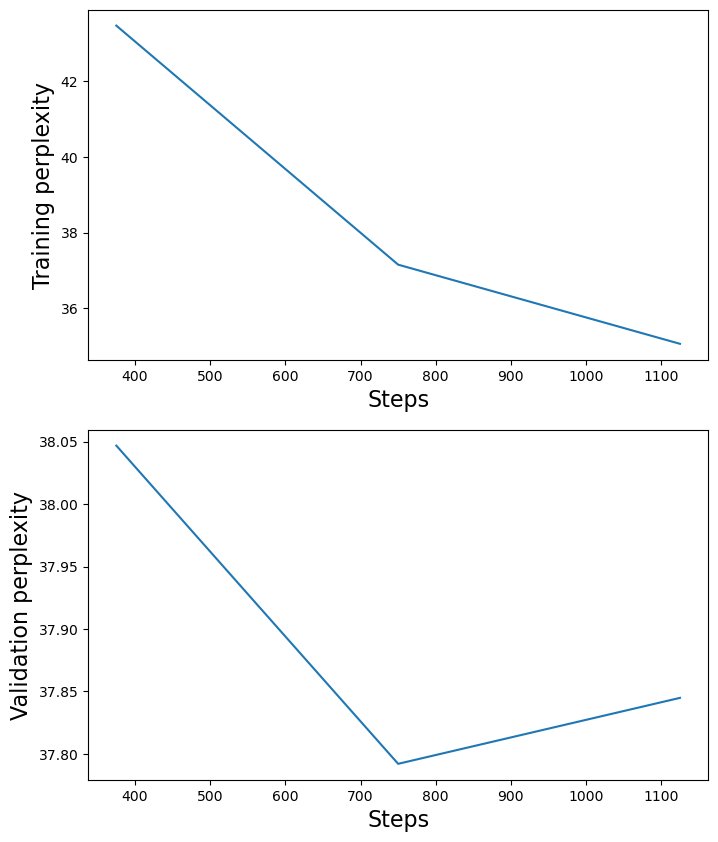

In [9]:
plot_perplexity(trainer.state.log_history, cfg.fig_path, cfg.dpi)

In [15]:
reviews = [
    "This movie was terrible. The acting was ",
    "Wow! I was suprised by how much I ",
    "I highly recommend this movie and ",
    "This was a horrible ",
    "I do not recommend this movie. The actors ",
    "This film was an incredible surprise. The acting was "
]

inputs = tokenizer(
    reviews,
    padding=True,
    truncation=True,
    return_tensors="pt"
)
inputs = to_device(inputs, device)

model.eval()
with tc.no_grad():
    outputs = model.generate(
        **inputs, 
        max_new_tokens=25,
        do_sample=True,
        top_k=25,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.pad_token_id
    )

for i, seq in enumerate(outputs):
    print(f"Seq. {i + 1}:")
    print(f"{tokenizer.decode(seq, skip_special_tokens=True)}")
    print("\n")

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Seq. 1:
This movie was terrible. The acting was I would give it a 10 out of ten rating on this one, but i don't think anyone saw the whole thing and


Seq. 2:
Wow! I was suprised by how much I iced this movie. The only bad thing about it is that the director didn't have a lot of time to write his screenplay


Seq. 3:
I highly recommend this movie and The Legend of the Jedi. I watched it on DVD with my wife in 2002, but we were all too busy watching "


Seq. 4:
This was a horrible It's all about the "big guys" who have their own agenda but that can't be true. The main reason for


Seq. 5:
I do not recommend this movie. The actors The director and the acting are terrible, it is a total waste of time to watch such an awful film as This Is NOT


Seq. 6:
This film was an incredible surprise. The acting was It really seemed a little bit out of place, and the cinematography is just plain wrong-headed but I felt it had




## Parameters explanation:
    1. **inputs
        * Actually splits up into
            - input_ids=inputs["input_ids"],
            - attention_mask=inputs["attention_mask"]
    2. do_sample
        * Tells model to sample from probability distribution instead of picking the highest-probability token.
        do_sample = False -> deterministic
        do_sample = True -> random sampling
    3. top_k
        * Sorts logits and keepstop 50 most probably tokens. Then samples from here.
        * Lower k -> more deterministic
        * Higher k -> more random
    4. top_p = 0.95
        * Keeps the smallest set of tokens whose cumulative probability >= 0.95
        * Can be used in conjunction with top_k, which amounts to picking tokens that intersect with these two conditions.
        * Helps adapt to uncertainty.
    5. temperature
        * Scales softmax distribution before sampling
        * Lower T -> more deterministic
        * Higher T -> more random
    6. num_return_sequences
        * Generates N number of separate continuations (predictions) for the input text.